In [1]:
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Conv2DTranspose, Input, concatenate, Activation
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

mixed_precision.set_global_policy('mixed_float16')

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
def load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path):
    """
    Reads three grayscale images and combines them into an RGB image.

    - brain_bone_window → Red channel
    - brain_window → Green channel
    - subdural_window → Blue channel

    Returns a (H, W, 3) RGB image.
    """
    # Load grayscale images
    brain_bone = cv2.imread(brain_bone_path, cv2.IMREAD_GRAYSCALE)
    brain = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
    subdural = cv2.imread(subdural_path, cv2.IMREAD_GRAYSCALE)

    # Ensure all images are the same shape
    if not (brain_bone.shape == brain.shape == subdural.shape):
        raise ValueError("Input images do not have same size")

    if not (brain_bone.shape == (512, 512)):
        print("\nbrain_bone.shape = ", brain_bone.shape, "\tbrain.shape = ", brain.shape, "\tsubdural.shape = ",
              subdural.shape)
        print("Path = ", brain_bone_path)

    # Normalize pixel values to [0,1] (optional, but recommended)
    brain_bone = brain_bone / 255.0
    brain = brain / 255.0
    subdural = subdural / 255.0

    # Stack images into an RGB format
    rgb_image = np.stack([brain_bone, brain, subdural], axis=-1)

    # Convert back to 0-255 and uint8 for visualization/saving
    # rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image


def find_matching_image_paths(bone_folder, brain_folder, subdural_folder, mask_folder):
    """
    Walks through the subfolders and finds images with the same filename across all three directories.

    Returns a list of tuples containing matching image paths from each folder.
    """
    # Get the list of all image filenames in each directory
    bone_images = set(os.listdir(bone_folder))
    brain_images = set(os.listdir(brain_folder))
    subdural_images = set(os.listdir(subdural_folder))
    mask_images = set(os.listdir(mask_folder))

    # Find common filenames across all three folders
    common_files = bone_images.intersection(brain_images).intersection(subdural_images).intersection(mask_images)

    # Create a list of tuples with paths to the matching images
    matching_image_paths = []
    for filename in common_files:
        bone_path = os.path.join(bone_folder, filename)
        brain_path = os.path.join(brain_folder, filename)
        subdural_path = os.path.join(subdural_folder, filename)
        mask_path = os.path.join(mask_folder, filename)
        matching_image_paths.append((bone_path, brain_path, subdural_path, mask_path))

    return matching_image_paths


def build_unet(input_shape):
    """
    Simplified U-Net model for brain hemorrhage segmentation.
    Reduced complexity for faster training.
    """
    # inputs = keras.Input(shape=input_shape)
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder - fewer filters, one less level
    c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)  # 256x256

    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)  # 128x128

    # Bridge - fewer filters
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)

    # Decoder - fewer filters, one less level
    u4 = Conv2D(16, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c3))  # 256x256
    u4 = tf.keras.layers.concatenate([u4, c2])
    c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)

    u5 = Conv2D(8, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c4))  # 512x512
    u5 = tf.keras.layers.concatenate([u5, c1])
    c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def build_medium_unet(input_shape):
    """
    Larger U-Net model
    """
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    # Decoder
    u5 = Conv2D(64, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c4))
    u5 = tf.keras.layers.concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2D(32, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c5))
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2D(16, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c6))
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def build_enhanced_unet(input_shape):
    """
    Enhanced U-Net model with:
    - Larger convolution kernels (5x5, 7x7) at strategic layers
    - Optimized skip connections
    - Dropout for regularization
    """
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder
    # First level with 3x3 convolutions
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Second level with 5x5 convolution for increased receptive field
    c2 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Third level with 5x5 convolution
    c3 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = Dropout(0.2)(c3)  # Adding dropout for regularization
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    # Using 7x7 convolution at the bottleneck for maximum receptive field
    c4 = Conv2D(128, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = Dropout(0.3)(c4)  # Higher dropout rate at the bottleneck

    # Decoder with optimized skip connections
    # First upsampling
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c4)
    # Explicit copy and crop (already handled by concatenate)
    u5 = tf.keras.layers.concatenate([u5, c3])  # Skip connection from encoder
    c5 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Second upsampling
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c5)
    # Explicit copy and crop (already handled by concatenate)
    u6 = tf.keras.layers.concatenate([u6, c2])  # Skip connection from encoder
    c6 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Third upsampling
    u7 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c6)
    # Explicit copy and crop (already handled by concatenate)
    u7 = tf.keras.layers.concatenate([u7, c1])  # Skip connection from encoder
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def build_unet_with_pretrained_encoder(input_shape=(512, 512, 3), encoder_type='resnet50', pretrained=True):
    """
    Build U-Net with a pre-trained encoder backbone

    Args:
        input_shape: Input shape of the images
        encoder_type: 'resnet50' or 'xception'
        pretrained: Whether to use pre-trained weights (True) or random initialization (False)

    Returns:
        U-Net model with pre-trained encoder
    """
    inputs = Input(shape=input_shape)

    # Select pre-trained encoder
    if encoder_type == 'resnet50':
        weights = 'imagenet' if pretrained else None
        base_model = ResNet50(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers
        s1 = base_model.get_layer('conv1_relu').output       # 256x256
        s2 = base_model.get_layer('conv2_block3_out').output  # 128x128
        s3 = base_model.get_layer('conv3_block4_out').output  # 64x64
        s4 = base_model.get_layer('conv4_block6_out').output  # 32x32

        # Bridge
        bridge = base_model.get_layer('conv5_block3_out').output  # 16x16

    elif encoder_type == 'xception':
        weights = 'imagenet' if pretrained else None
        base_model = Xception(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers with care for dimensions
        s1 = base_model.get_layer('block2_sepconv2_act').output  # Adjust layer names if needed
        s2 = base_model.get_layer('block3_sepconv2_act').output
        s3 = base_model.get_layer('block4_sepconv2_act').output
        s4 = base_model.get_layer('block13_sepconv2_act').output

        # Bridge
        bridge = base_model.get_layer('block14_sepconv2_act').output

        print(f"s1 shape: {s1.shape}")
        print(f"s2 shape: {s2.shape}")
        print(f"s3 shape: {s3.shape}")
        print(f"s4 shape: {s4.shape}")
        print(f"bridge shape: {bridge.shape}")

    else:
        raise ValueError(f"Unsupported encoder type: {encoder_type}. Choose 'resnet50' or 'xception'")

    # Decoder path
    # First upsampling block
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(bridge)
    u1 = concatenate([u1, s4])
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Dropout(0.2)(u1)

    # Second upsampling block
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, s3])
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Dropout(0.2)(u2)

    # Third upsampling block
    u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u2)
    u3 = concatenate([u3, s2])
    u3 = Conv2D(128, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Conv2D(128, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    # Fourth upsampling block
    u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u3)
    u4 = concatenate([u4, s1], axis=3)
    u4 = Conv2D(64, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Conv2D(64, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    # Final upsampling block to match input size (if necessary based on input shape)
    # For 512x512 input with ResNet/Xception, we need one more upsampling layer
    u5 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(u4)
    u5 = Conv2D(32, (3, 3), padding='same')(u5)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)
    u5 = Conv2D(32, (3, 3), padding='same')(u5)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u5)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Optional: Function to freeze/unfreeze encoder layers
def set_encoder_trainable(model, trainable=False):
    """
    Set trainable property of the encoder layers

    Args:
        model: The U-Net model with pre-trained encoder
        trainable: Whether to make encoder layers trainable (True) or frozen (False)
    """
    # Find the pre-trained backbone layers
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model):  # This is the base model
            for base_layer in layer.layers:
                base_layer.trainable = trainable

    return model

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def show_predictions_dyn(model, dataset, num_batches=1,num_in_batch=5):
    for batch in range(num_batches):
        for images, masks in dataset.take(batch):
            preds = model.predict(images)

            for i in range(num_in_batch):
                image = images[i]
                true_mask = masks[i]
                pred_mask = preds[i]

                # Threshold predicted mask for display
                pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image.numpy())
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("True Mask")
                plt.imshow(tf.squeeze(true_mask), cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(tf.squeeze(pred_mask), cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

def show_predictions_dyn_var(model, dataset, num_batches=1,num_in_batch=5, threshold=0.5):
    for batch in range(num_batches):
        for images, masks in dataset.take(batch):
            preds = model.predict(images)

            for i in range(num_in_batch):
                image = images[i]
                true_mask = masks[i]
                pred_mask = preds[i]

                # Threshold predicted mask for display
                pred_mask_bin = tf.where(pred_mask > threshold, 1.0, 0.0)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 4, 1)
                plt.title("Original Image")
                plt.imshow(image.numpy())
                plt.axis('off')

                plt.subplot(1, 4, 2)
                plt.title("True Mask")
                plt.imshow(tf.squeeze(true_mask), cmap='gray')
                plt.axis('off')

                plt.subplot(1, 4, 3)
                plt.title("Predicted Mask")
                plt.imshow(tf.squeeze(pred_mask), cmap='gray')
                plt.axis('off')

                plt.subplot(1, 4, 4)
                plt.title("Binary Predicted Mask")
                plt.imshow(tf.squeeze(pred_mask_bin), cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

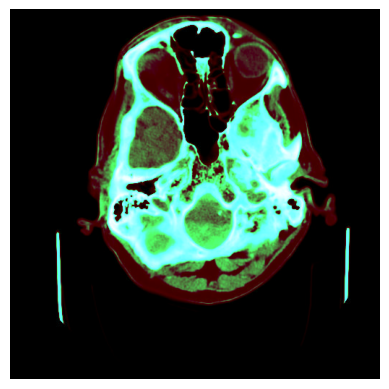

(512, 512, 3)

In [3]:
# Example usage
brain_bone_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/brain_bone_window/ID_0a1a010bf.jpg"
brain_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/brain_window/ID_0a1a010bf.jpg"
subdural_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/subdural_window/ID_0a1a010bf.jpg"

rgb_image = load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path)

plt.imshow(rgb_image)
plt.axis("off")
plt.show()

rgb_image.shape

In [4]:
bone_folder = 'Hemorrhage3000/brain_bone_window'
brain_folder = 'Hemorrhage3000/brain_window'
subdural_folder = 'Hemorrhage3000/subdural_window'

mask_folder = 'Hemorrhage3000/MasksData/bi-masks'
# mask_folder = 'Hemorrhage3000/MasksData/qu-masks'

matching_paths = find_matching_image_paths(bone_folder, brain_folder, subdural_folder, mask_folder)

In [6]:
brain_img = []
mask_img = []

for paths in matching_paths:
    rgb_image = load_and_stack_as_rgb(paths[0], paths[1], paths[2])
    mask_image = cv2.imread(paths[3], cv2.IMREAD_GRAYSCALE)
    mask_image = mask_image / 255.0
    mask_image = (mask_image > 0).astype(np.float32)

    if (mask_image.shape == (512, 512)) & (rgb_image.shape == (512, 512, 3)):
        brain_img.append(np.array(rgb_image))
        mask_img.append(np.array(mask_image))

print(len(brain_img))
print(brain_img[0].shape)

print(len(mask_img))
print(mask_img[0].shape)


brain_bone.shape =  (462, 462) 	brain.shape =  (462, 462) 	subdural.shape =  (462, 462)
Path =  Hemorrhage3000/brain_bone_window\ID_c6463f07d.jpg

brain_bone.shape =  (638, 490) 	brain.shape =  (638, 490) 	subdural.shape =  (638, 490)
Path =  Hemorrhage3000/brain_bone_window\ID_88b0d8b4f.jpg
2899
(512, 512, 3)
2899
(512, 512)


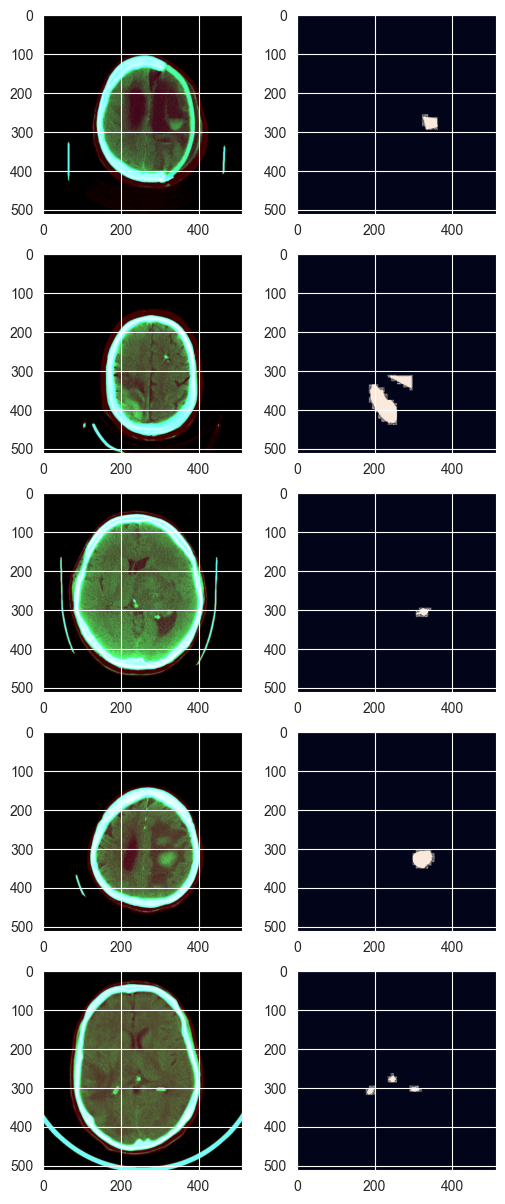

In [7]:
num_to_disp = 5

plt.figure(figsize=(6, 3 * num_to_disp))
for index in range(num_to_disp):
    plt.subplot(num_to_disp, 2, index * 2 + 1)
    plt.imshow(brain_img[index])
    plt.axis("on")

    plt.subplot(num_to_disp, 2, index * 2 + 2)
    plt.imshow(mask_img[index])
    plt.axis("on")

plt.show()

In [8]:
# Create a dataset from indices instead of the actual images
train_percentage = 0.8
validate_percentage = 0.1
test_percentage = 0.1

indices_dataset = tf.data.Dataset.from_tensor_slices(np.arange(len(brain_img)))
indices_dataset = indices_dataset.shuffle(buffer_size=len(brain_img))

# Function to load a single image pair by index
def load_image_mask_pair(idx):
    brain = tf.convert_to_tensor(brain_img[idx.numpy()], dtype=tf.float32)
    mask = tf.convert_to_tensor(mask_img[idx.numpy()], dtype=tf.float32)
    return brain, mask

# Modify your dataset mapping function
def tf_load_pair(idx):
    brain, mask = tf.py_function(
        load_image_mask_pair, [idx], [tf.float32, tf.float32]
    )
    brain.set_shape([512, 512, 3])
    mask.set_shape([512, 512])
    # Expand dimensions to add channel dimension for the mask
    mask = tf.expand_dims(mask, axis=-1)
    return brain, mask

# Apply the loading function to create the final dataset
dataset = indices_dataset.map(tf_load_pair)

# Split into train, validation, and test
train_size = int(train_percentage * len(brain_img))
val_size = int(validate_percentage * len(brain_img))

train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# Batch the datasets
BATCH_SIZE = 2  # Try smaller batch size if memory is still an issue
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Images shape: (2, 512, 512, 3)
Masks shape: (2, 512, 512, 1)
Unique values in masks: [0. 1.]
[0. 1.]


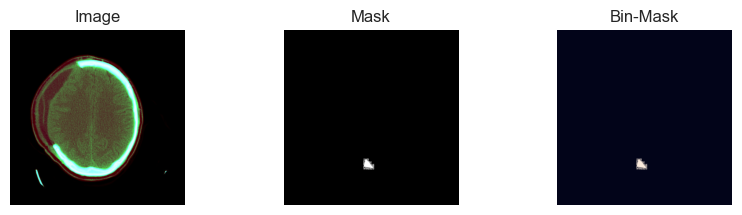

[0. 1.]


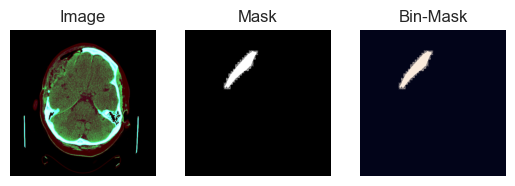

In [9]:
# Check if the dataset is working
for images, masks in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)
    print("Unique values in masks:", np.unique(masks.numpy()))

    # Visualize a few examples
    disp_num = 2
    plt.figure(figsize=(10, 5))
    for i in range(min(disp_num, images.shape[0])):
        mask_im = masks[i].numpy()
        print(np.unique(mask_im))
        binary_im = (masks[i].numpy() > 0.5).astype(np.float32)

        plt.subplot(disp_num, 3, i*3+1)
        plt.imshow(images[i].numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(disp_num, 3, i*3+2)
        plt.imshow(masks[i].numpy(), cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(disp_num, 3, i*3+3)
        plt.imshow(binary_im)
        plt.title("Bin-Mask")
        plt.axis("off")
        plt.show()


In [11]:
# Define input shape
input_shape = (512, 512, 3)

# Create the model with pre-trained encoder (options: 'resnet50' or 'xception')
model20 = build_unet_with_pretrained_encoder(
    input_shape=input_shape,
    encoder_type='resnet50',  # or 'xception'
    pretrained=True
)

# Optionally freeze encoder weights for transfer learning
model20 = set_encoder_trainable(model20, trainable=False)

# Compile model20
model20.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model20
# model20.summary()

# Train the model20
history = model20.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model20.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9063 - loss: 0.7307 - precision: 0.1186 - recall: 0.6758

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 7145s 6s/step - accuracy: 0.9063 - loss: 0.7306 - precision: 0.1187 - recall: 0.6757 - val_accuracy: 0.9607 - val_loss: 0.6506 - val_precision: 0.2191 - val_recall: 0.7817 - learning_rate: 0.0010


In [12]:
model20.load_weights('best_model20.h5')
test_loss, test_acc, test_prec, test_recall = model20.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9588 - loss: 0.6513 - precision: 0.2298 - recall: 0.6577
Test Accuracy: 0.9596, Precision: 0.2181, Recall: 0.6412


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


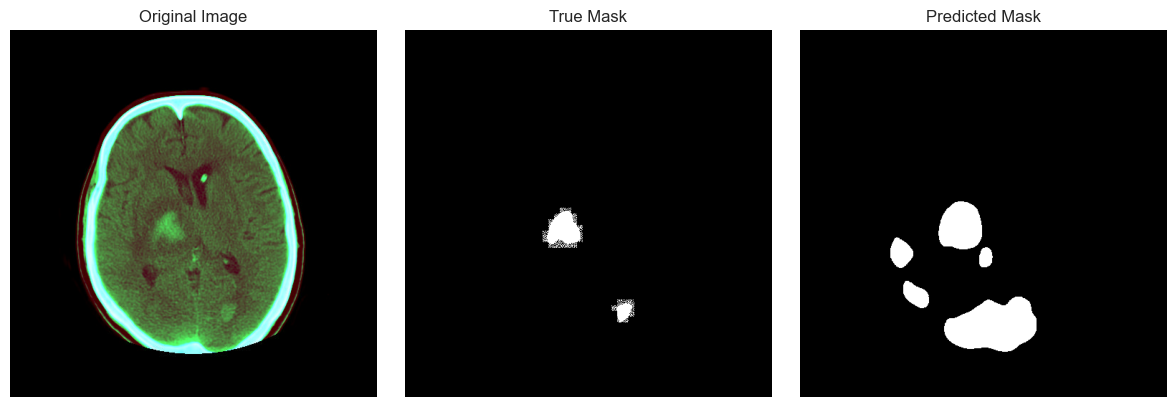

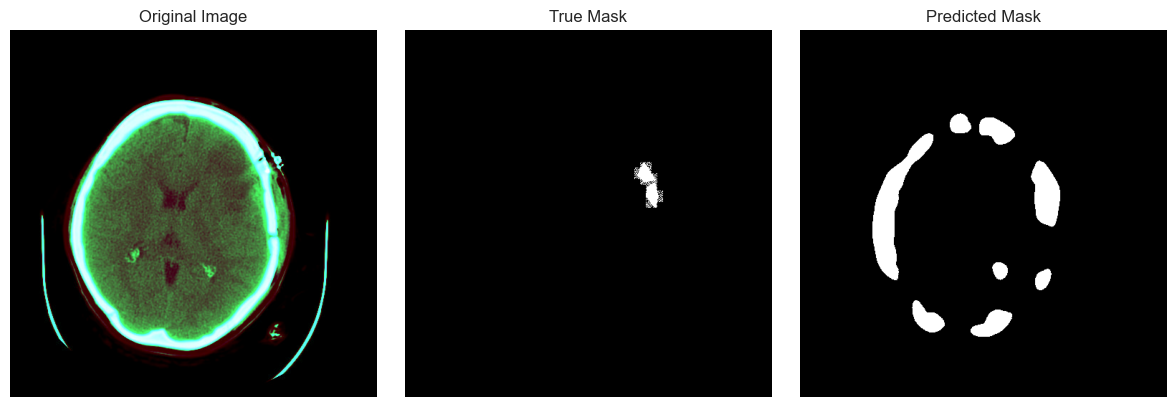

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


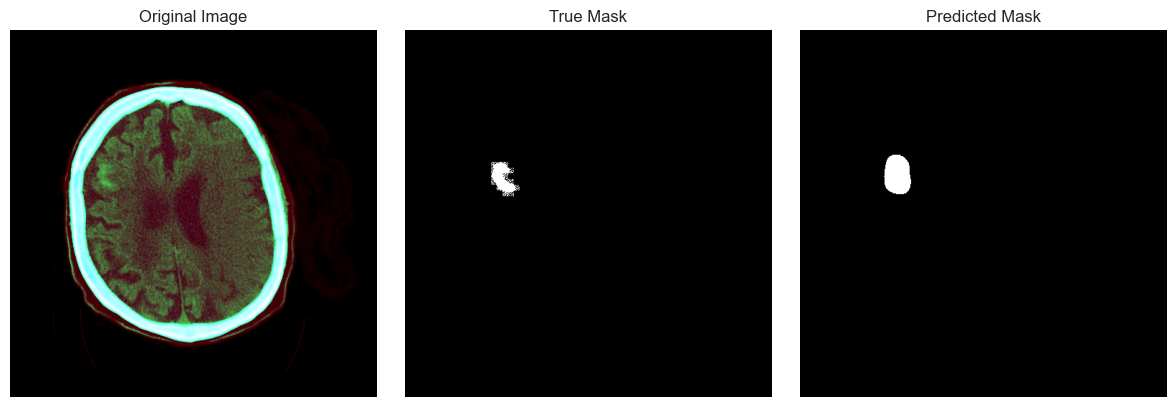

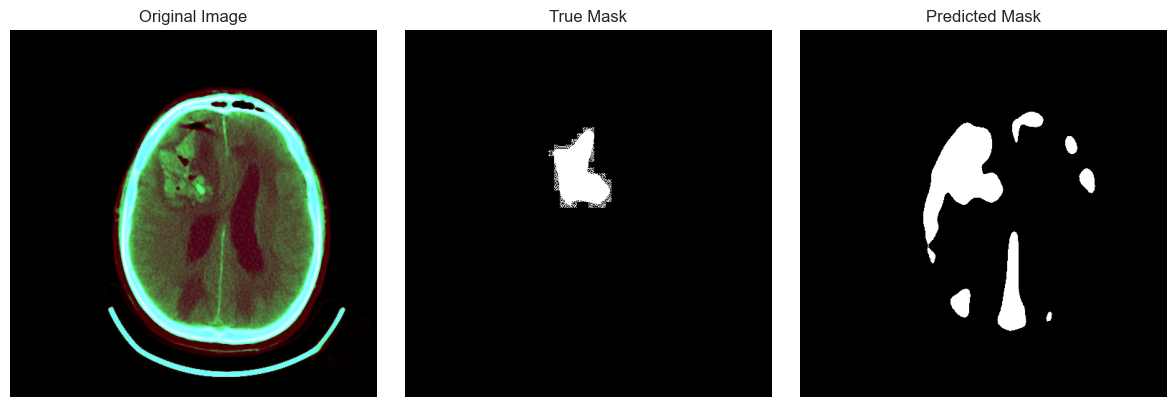

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


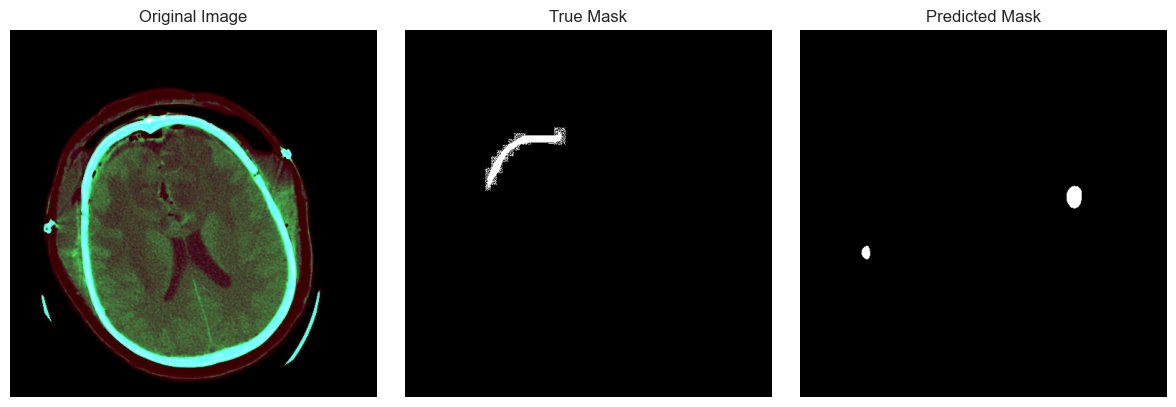

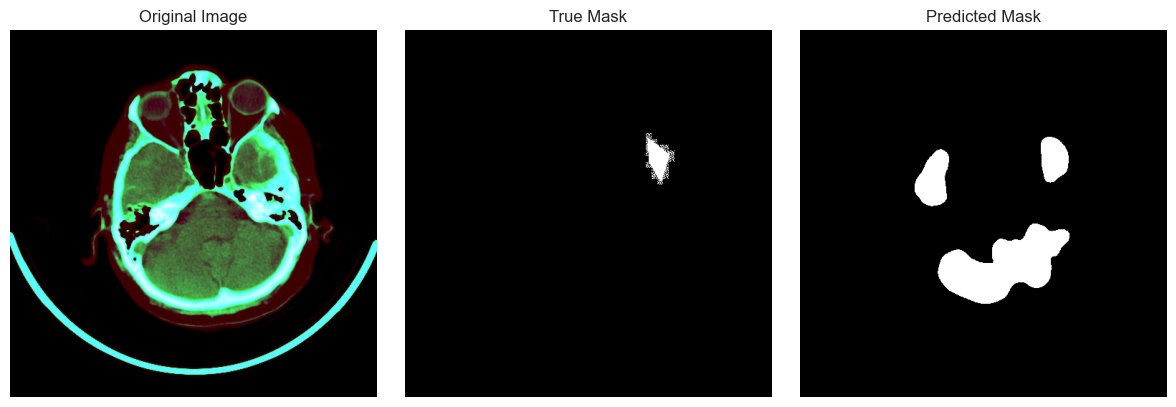

In [13]:
show_predictions_dyn(model20, test_dataset, num_batches=3, num_in_batch=2)

In [8]:
# Define input shape
input_shape = (512, 512, 3)

# Create the model with pre-trained encoder (options: 'resnet50' or 'xception')
model21 = build_unet_with_pretrained_encoder(
    input_shape=input_shape,
    encoder_type='resnet50',  # or 'xception'
    pretrained=True
)

# Optionally freeze encoder weights for transfer learning
model21 = set_encoder_trainable(model21, trainable=False)

# Compile model21
model21.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:

# Print a summary of the model21
# model21.summary()

# Train the model21
history = model21.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model21.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=15,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/30


In [9]:
model21.load_weights('best_model21.h5')
test_loss, test_acc, test_prec, test_recall = model21.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9906 - loss: 0.4032 - precision: 0.6392 - recall: 0.6238
Test Accuracy: 0.9894, Precision: 0.6232, Recall: 0.5665


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


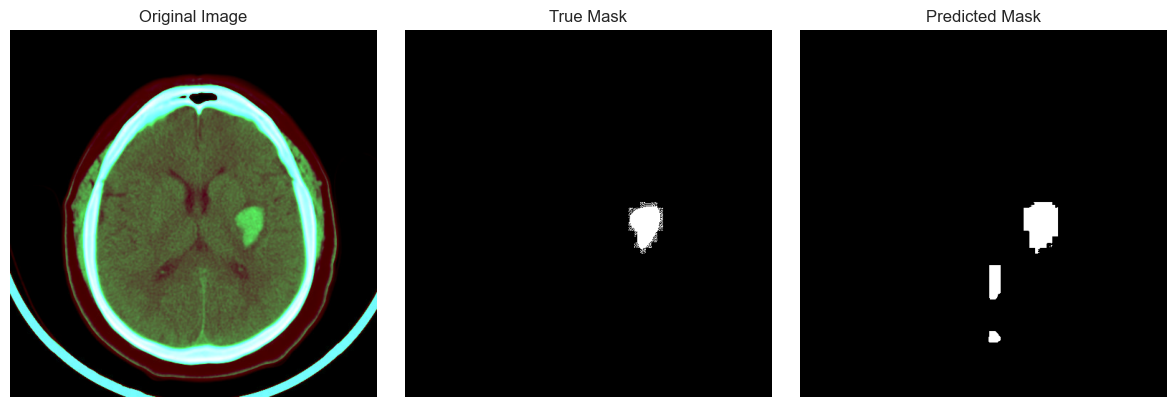

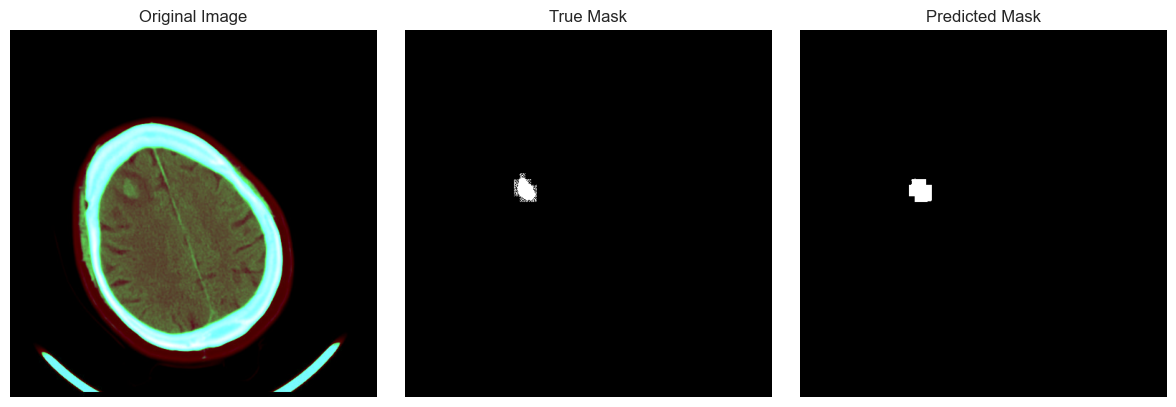

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


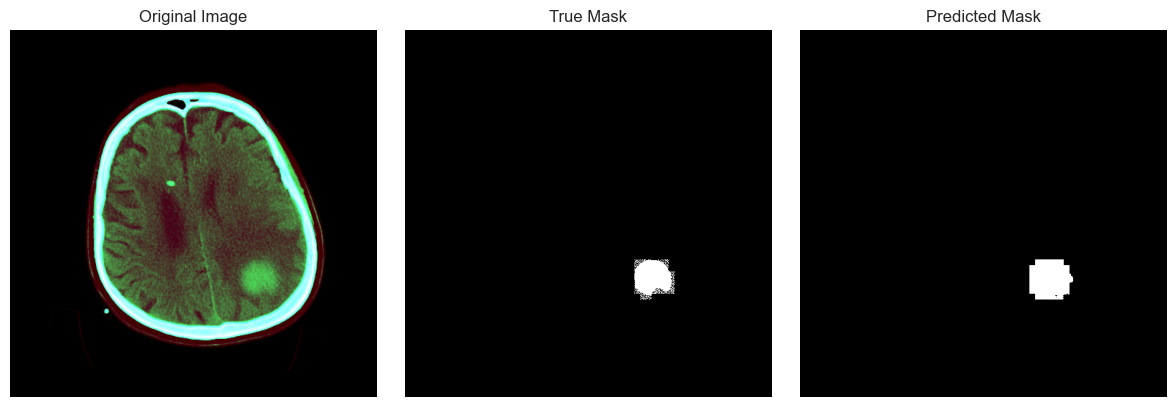

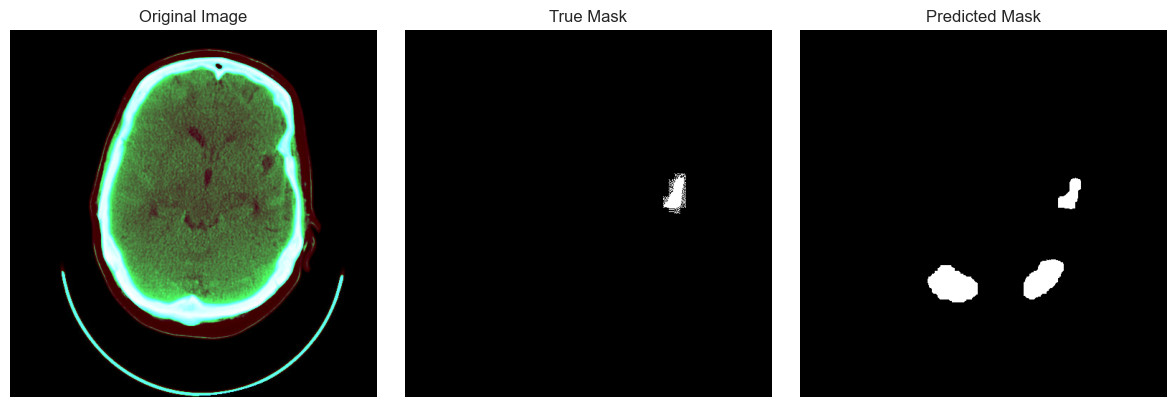

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


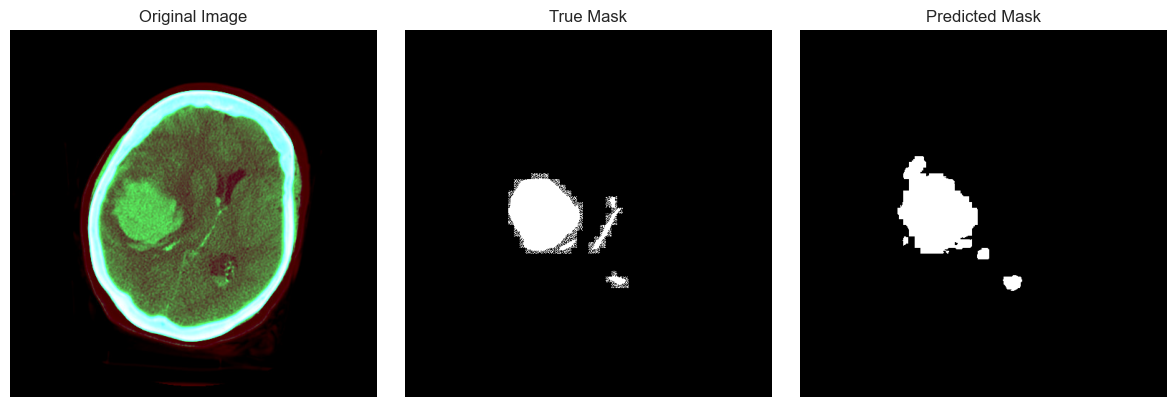

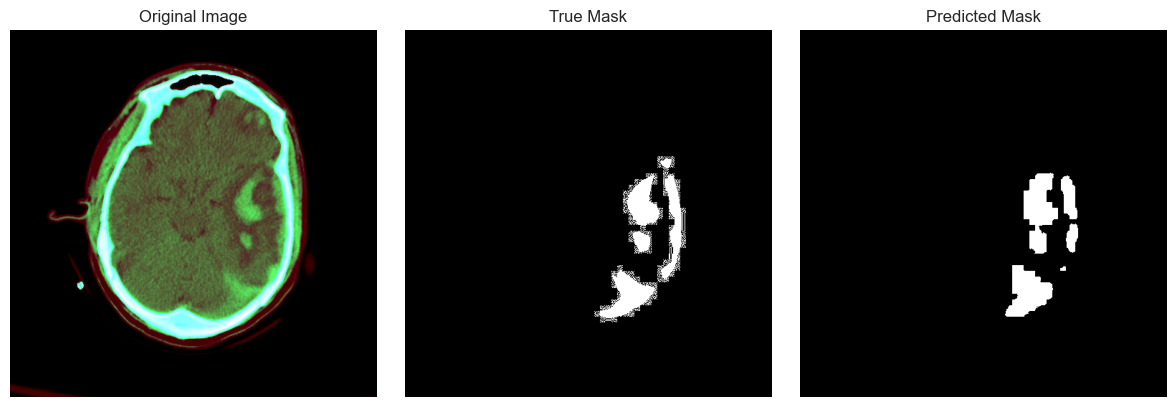

In [10]:
show_predictions_dyn(model21, test_dataset, num_batches=3, num_in_batch=2)

Epoch 1/10


In [17]:
def build_unet_with_pretrained_encoder2(input_shape=(512, 512, 3), encoder_type='xception', pretrained=True):
    """
    Build U-Net with a pre-trained encoder backbone
    """
    inputs = Input(shape=input_shape)

    # Select pre-trained encoder
    if encoder_type == 'xception':
        weights = 'imagenet' if pretrained else None
        base_model = Xception(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers - store their shapes
        s1 = base_model.get_layer('block2_sepconv2_act').output  # (None, 253, 253, 128)
        s2 = base_model.get_layer('block3_sepconv2_act').output  # (None, 127, 127, 256)
        s3 = base_model.get_layer('block4_sepconv2_act').output  # (None, 64, 64, 728)
        s4 = base_model.get_layer('block13_sepconv2_act').output  # (None, 32, 32, 728)

        # Bridge
        bridge = base_model.get_layer('block14_sepconv2_act').output  # (None, 16, 16, 2048)

    elif encoder_type == 'resnet50':
        # Your existing ResNet50 code...
        pass

    else:
        raise ValueError(f"Unsupported encoder type: {encoder_type}. Choose 'resnet50' or 'xception'")

    # Decoder path with precise resizing to match skip connection dimensions

    # First upsampling block: 16x16 -> 32x32 (to match s4)
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(bridge)  # 32x32

    # Ensure u1 matches s4 exactly
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = concatenate([u1, s4])
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Dropout(0.2)(u1)

    # Second upsampling block: 32x32 -> 64x64 (to match s3)
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u1)  # 64x64

    # Ensure u2 matches s3 exactly
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = concatenate([u2, s3])
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Dropout(0.2)(u2)

    # Third upsampling block: 64x64 -> 127x127 (needs to exactly match s2)
    # We'll use a custom size for upsampling
    u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u2)  # 128x128

    # Resize explicitly to match s2's dimensions
    u3 = tf.keras.layers.Cropping2D(cropping=((0, 1), (0, 1)))(u3)  # Crop to 127x127
    u3 = concatenate([u3, s2])
    u3 = Conv2D(128, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    # Fourth upsampling block: 127x127 -> 253x253 (to match s1)
    # Use a custom size for upsampling that produces 254x254, then crop
    u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u3)  # 254x254

    # Resize explicitly to match s1's dimensions
    u4 = tf.keras.layers.Cropping2D(cropping=((0, 1), (0, 1)))(u4)  # Crop to 253x253
    u4 = concatenate([u4, s1])
    u4 = Conv2D(64, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    # Final upsampling block: 253x253 -> 512x512 (output size)
    # Calculate the scaling factor: approx 2.02x
    u5 = tf.keras.layers.UpSampling2D(size=(2.024, 2.024), interpolation='bilinear')(u4)
    u5 = Conv2D(32, (3, 3), padding='same')(u5)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u5)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
def build_unet_with_pretrained_encoder3(input_shape=(512, 512, 3), encoder_type='xception', pretrained=True):
    inputs = Input(shape=input_shape)

    # Initialize Xception encoder
    weights = 'imagenet' if pretrained else None
    base_model = Xception(include_top=False, weights=weights, input_tensor=inputs)

    # Extract skip connections
    s1 = base_model.get_layer('block2_sepconv2_act').output  # 253x253
    s2 = base_model.get_layer('block3_sepconv2_act').output  # 127x127
    s3 = base_model.get_layer('block4_sepconv2_act').output  # 64x64
    s4 = base_model.get_layer('block13_sepconv2_act').output  # 32x32
    bridge = base_model.get_layer('block14_sepconv2_act').output  # 16x16

    # Decoder path with resize operations
    # First upsampling: 16x16 -> 32x32
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(bridge)
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = concatenate([u1, s4])
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)

    # Second upsampling: 32x32 -> 64x64
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = concatenate([u2, s3])
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)

    # Third upsampling: 64x64 -> 128x128 -> 127x127
    u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u2)
    # Use Lambda to resize to exactly match s2 dimensions
    u3 = Lambda(lambda x: tf.image.resize(x, [127, 127]))(u3)
    u3 = concatenate([u3, s2])
    u3 = Conv2D(128, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    # Fourth upsampling: 127x127 -> 254x254 -> 253x253
    u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u3)
    # Use Lambda to resize to exactly match s1 dimensions
    u4 = Lambda(lambda x: tf.image.resize(x, [253, 253]))(u4)
    u4 = concatenate([u4, s1])
    u4 = Conv2D(64, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    # Final upsampling to match input size: 253x253 -> 512x512
    u5 = Lambda(lambda x: tf.image.resize(x, [512, 512]))(u4)
    u5 = Conv2D(32, (3, 3), padding='same')(u5)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u5)
    outputs = Activation('sigmoid', dtype='float32')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def build_unet_with_pretrained_encoder4(input_shape=(512, 512, 3), encoder_type='xception', pretrained=True):
    from tensorflow.keras.layers import Lambda, Input, Conv2D, Conv2DTranspose, concatenate, Activation, BatchNormalization
    from tensorflow.keras.models import Model

    inputs = Input(shape=input_shape)

    # Initialize Xception encoder
    weights = 'imagenet' if pretrained else None
    base_model = Xception(include_top=False, weights=weights, input_tensor=inputs)

    # Extract skip connections
    s1 = base_model.get_layer('block2_sepconv2_act').output  # 253x253
    s2 = base_model.get_layer('block3_sepconv2_act').output  # 127x127
    s3 = base_model.get_layer('block4_sepconv2_act').output  # 64x64
    s4 = base_model.get_layer('block13_sepconv2_act').output  # 32x32
    bridge = base_model.get_layer('block14_sepconv2_act').output  # 16x16

    # Decoder path with resize operations
    # First upsampling: 16x16 -> 32x32
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(bridge)
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = concatenate([u1, s4])
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)

    # Second upsampling: 32x32 -> 64x64
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = concatenate([u2, s3])
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)

    # Third upsampling: 64x64 -> 128x128 -> 127x127
    u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u2)
    # Use Lambda to resize to exactly match s2 dimensions
    u3 = Lambda(lambda x: tf.image.resize(x, [127, 127]))(u3)
    u3 = concatenate([u3, s2])
    u3 = Conv2D(128, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    # Fourth upsampling: 127x127 -> 254x254 -> 253x253
    u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u3)
    # Use Lambda to resize to exactly match s1 dimensions
    u4 = Lambda(lambda x: tf.image.resize(x, [253, 253]))(u4)
    u4 = concatenate([u4, s1])
    u4 = Conv2D(64, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    # Final upsampling to match input size: 253x253 -> 512x512
    u5 = Lambda(lambda x: tf.image.resize(x, [512, 512]))(u4)
    u5 = Conv2D(32, (3, 3), padding='same')(u5)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u5)
    outputs = Activation('sigmoid', dtype='float32')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
# Define input shape
input_shape = (512, 512, 3)

# Create the model with pre-trained encoder (options: 'resnet50' or 'xception')
model23 = build_unet_with_pretrained_encoder(
    input_shape=input_shape,
    encoder_type='resnet50',  # or 'xception'
    pretrained=True
)

# Optionally freeze encoder weights for transfer learning
model23 = set_encoder_trainable(model23, trainable=False)

# Compile model21
model23.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model23.load_weights('best_model21.h5')

In [37]:
# Compile model22
model23.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model22
# model22.summary()

# Train the model22
history = model23.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model23.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=15,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9894 - loss: 0.4329 - precision_10: 0.6170 - recall_10: 0.5297

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 7050s 6s/step - accuracy: 0.9894 - loss: 0.4329 - precision_10: 0.6170 - recall_10: 0.5297 - val_accuracy: 0.9887 - val_loss: 0.5345 - val_precision_10: 0.6635 - val_recall_10: 0.4338 - learning_rate: 0.0010
Epoch 2/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9897 - loss: 0.4398 - precision_10: 0.6133 - recall_10: 0.5404

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 7030s 6s/step - accuracy: 0.9897 - loss: 0.4398 - precision_10: 0.6133 - recall_10: 0.5404 - val_accuracy: 0.9896 - val_loss: 0.4375 - val_precision_10: 0.6256 - val_recall_10: 0.5487 - learning_rate: 0.0010
Epoch 3/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 7012s 6s/step - accuracy: 0.9901 - loss: 0.4213 - precision_10: 0.6389 - recall_10: 0.5395 - val_accuracy: 0.9899 - val_loss: 0.4522 - val_precision_10: 0.6230 - val_recall_10: 0.5587 - learning_rate: 0.0010
Epoch 4/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 6988s 6s/step - accuracy: 0.9901 - loss: 0.4256 - precision_10: 0.6292 - recall_10: 0.5555 - val_accuracy: 0.9912 - val_loss: 0.4745 - val_precision_10: 0.7085 - val_recall_10: 0.5266 - learning_rate: 0.0010
Epoch 5/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 6993s 6s/step - accuracy: 0.9899 - loss: 0.4407 - precision_10: 0.6140 - recall_10: 0.5372 - val_accuracy: 0.9905 - val_loss: 0.4564 - val_precision_10: 0.5873 - val_recall_10: 0.5981 - learning_rate: 0.0010
Epoch 6/10


1160/1160 ━━━━━━━━━━━━━━━━━━━━ 7025s 6s/step - accuracy: 0.9899 - loss: 0.4313 - precision_10: 0.6068 - recall_10: 0.5619 - val_accuracy: 0.9905 - val_loss: 0.4270 - val_precision_10: 0.7316 - val_recall_10: 0.5382 - learning_rate: 1.0000e-04
Epoch 7/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 7086s 6s/step - accuracy: 0.9911 - loss: 0.3959 - precision_10: 0.6629 - recall_10: 0.5981 - val_accuracy: 0.9904 - val_loss: 0.4641 - val_precision_10: 0.6274 - val_recall_10: 0.5085 - learning_rate: 1.0000e-04
Epoch 8/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 6976s 6s/step - accuracy: 0.9910 - loss: 0.4050 - precision_10: 0.6692 - recall_10: 0.5652 - val_accuracy: 0.9914 - val_loss: 0.4870 - val_precision_10: 0.6796 - val_recall_10: 0.5221 - learning_rate: 1.0000e-04
Epoch 9/10
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 7040s 6s/step - accuracy: 0.9910 - loss: 0.3970 - precision_10: 0.6748 - recall_10: 0.5758 - val_accuracy: 0.9922 - val_loss: 0.4455 - val_precision_10: 0.6830 - val_recall_10: 0.5715 - learning_rate: 1.0000

In [38]:
model23.load_weights('best_model23.h5')
test_loss, test_acc, test_prec, test_recall = model23.evaluate(test_dataset)

146/146 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.9909 - loss: 0.4618 - precision_10: 0.6981 - recall_10: 0.5387


Test Accuracy: 0.9911, Precision: 0.6922, Recall: 0.5343
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


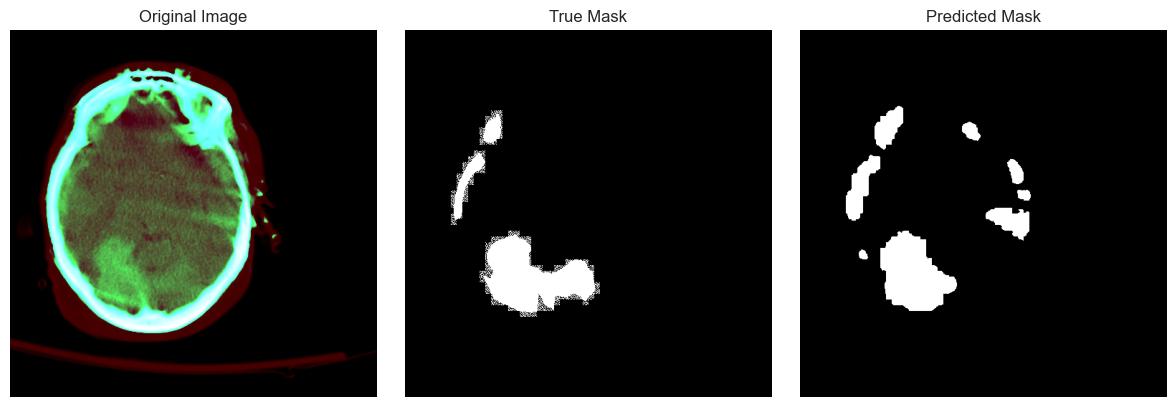

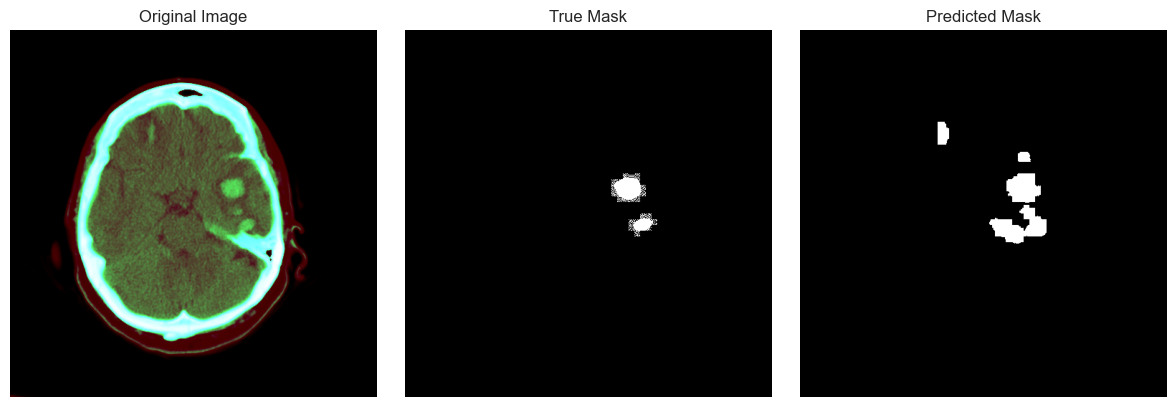

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


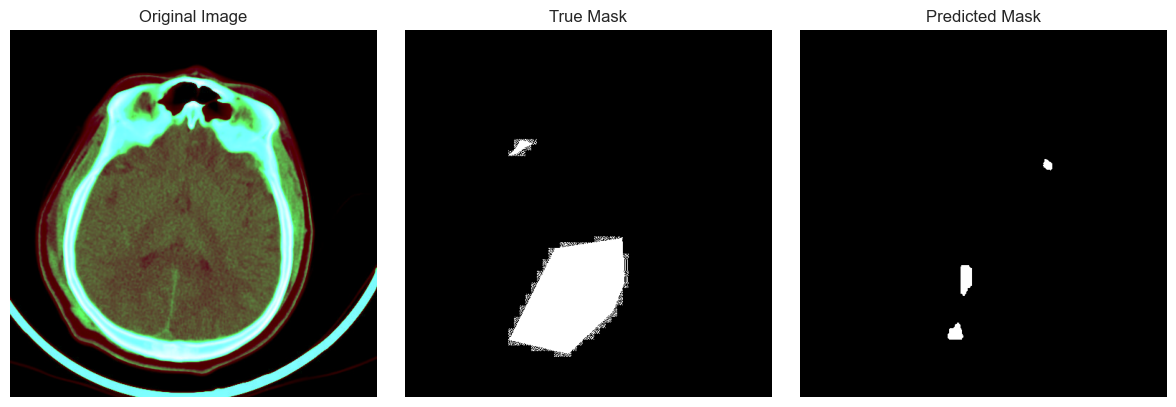

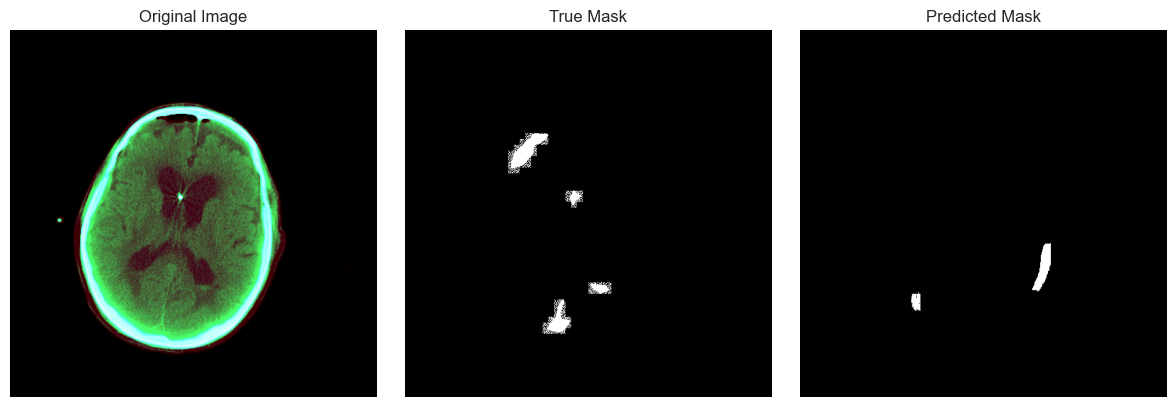

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


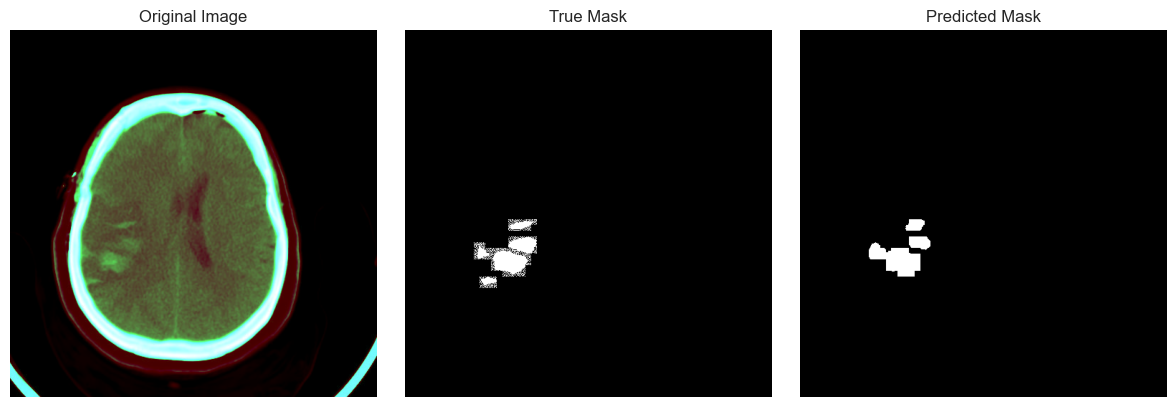

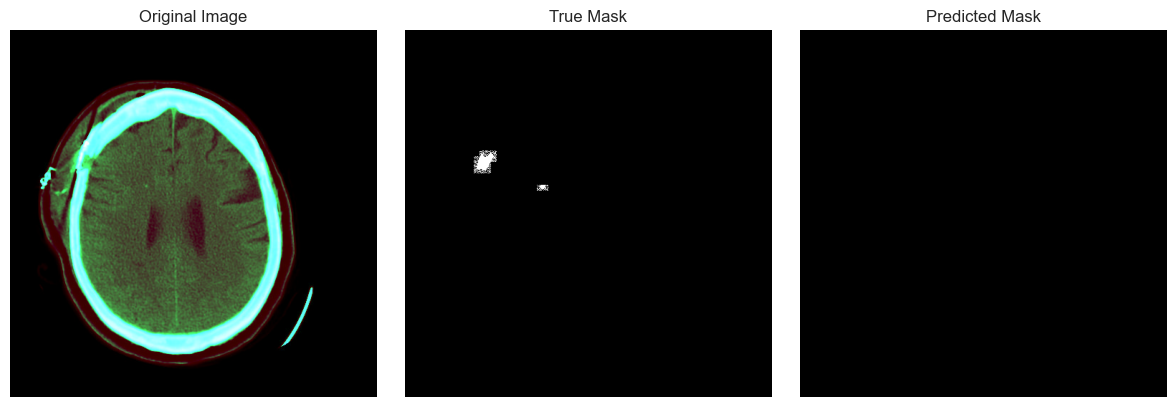

In [39]:
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")
show_predictions_dyn(model23, test_dataset, num_batches=3, num_in_batch=2)